### Diversity Score

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
from mapsgan import BaseSolver, experiments, data_loader
from mapsgan import ToyGenerator, ToyDiscriminator, BicycleGenerator, norm_scene, cos_scene
from mapsgan.evaluation import Visualization
from mapsgan.sgan import TrajectoryDiscriminator, TrajectoryGenerator
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
import os
model_path = '../models/cloud/'
os.listdir(model_path)

['bicy_enc_1_20190117-134649_epoch_10000',
 'bicy_weights_1_20190117-155010_epoch_10000',
 'bicy_weights_2_20190118-073226_epoch_70000',
 'bicy_weights__encoptim_3_20190118-124310_epoch_10000',
 'clr_1_20190114-160949_epoch_10000',
 'cvae_1_20190114-154818_epoch_10000',
 'sgan_1_20190117-055507_epoch_10000',
 'toymodel_1_20190117-172104_epoch_10000']

#### Init models/ solvers

In [2]:
in_len, out_len = 8, 12

toygenerator = ToyGenerator(in_len=in_len, out_len=out_len)
toydiscriminator = ToyDiscriminator()

bicyclegenerator = BicycleGenerator(ToyGenerator, start_mode='cvae')

sgangenerator = TrajectoryGenerator(obs_len=8,
                                pred_len=12,
                                embedding_dim=16,
                                encoder_h_dim=32,
                                decoder_h_dim=32,
                                mlp_dim=64,
                                num_layers=1,
                                noise_dim=(8,),
                                noise_type='gaussian',
                                noise_mix_type='global',
                                pooling_type='pool_net',
                                pool_every_timestep=1,
                                dropout=0,
                                bottleneck_dim=32,
                                neighborhood_size=2,
                                grid_size=8,
                                batch_norm=0)

In [3]:
solver = BaseSolver(toygenerator, toydiscriminator)

In [4]:
solver.generator = bicyclegenerator
solver.load_generator(model_path + '/' + 'bicy_enc_1_20190117-134649_epoch_10000')

In [5]:
models = {'Baseline':{'generator': toygenerator, 'ckpt': 'toymodel_1_20190117-172104_epoch_10000'},
          'cLR':{'generator': bicyclegenerator, 'ckpt': 'clr_1_20190114-160949_epoch_10000'},
          'cVAE':{'generator': bicyclegenerator, 'ckpt': 'cvae_1_20190114-154818_epoch_10000'},
          'Bicycle':{'generator': bicyclegenerator, 'ckpt': 'bicy_weights_1_20190117-155010_epoch_10000'},
          'SGAN':{'generator': sgangenerator, 'ckpt': 'sgan_1_20190117-055507_epoch_10000'},
          'cLRSGAN':{'generator': None, 'ckpt': ''},
          'cVAESGAN':{'generator': None, 'ckpt': ''},
          'BicycleSGAN':{'generator': None, 'ckpt': ''}}

In [6]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, trainloader = data_loader(in_len=8,
                                   out_len=12,
                                   batch_size=64,
                                   num_workers=1,
                                   path=experiment.test_dir,
                                   shuffle=False)

### Get cosine scores + l1 distance

In [8]:
def distance(xy_pred, xy_out):
    d = []
    for i, pred in enumerate(xy_pred):
        d.append(np.abs(pred.flatten()-xy_out[i].flatten()).mean())
    return np.mean(d)

In [9]:
cosine_score_model = {key:None for key in models}
l1_score_model = {key:None for key in models}

In [10]:
for model, item in models.items():
    if item['ckpt']:
        solver.generator = item['generator']
        solver.load_generator(model_path + item['ckpt'])
        out = solver.test(trainloader)
        xy_pred = out['xy_pred']
        xy_out = out['xy_out']
        l1_score_model[model] = distance(xy_pred, xy_out)
        xy_pred_normed = norm_scene(xy_pred)
        cosine_score_model[model] = cos_scene(xy_pred)

cosine_score_real = cos_scene(xy_out)
cosine_scores = {key:value/cosine_score_real for key, value in cosine_score_model.items() if value}
maxl1 = np.max([x for x in l1_score_model.values() if x])
l1_scores = {key: (maxl1-value)/maxl1  for key, value in l1_score_model.items() if value}

### Scatter plot

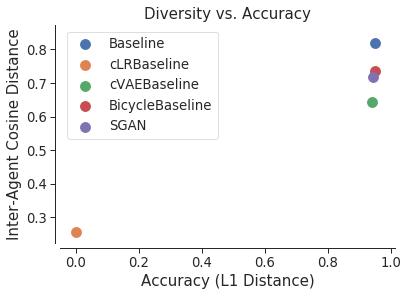

In [50]:
viz = Visualization()
ax = viz.plot.init_subplot(title='Diversity vs. Accuracy')

for model in cosine_scores:
    ax.scatter(l1_scores[model], cosine_scores[model], s=100, label=model,
               alpha=1)

ax.legend()
ax.set_ylabel('Inter-Agent Cosine Distance')
ax.set_xlabel('Accuracy (L1 Distance)')
#ax.grid(True)

plt.show()

In [75]:
order[::-1]

['SGAN', 'Baseline', 'cVAE', 'cLR', 'Bicycle']

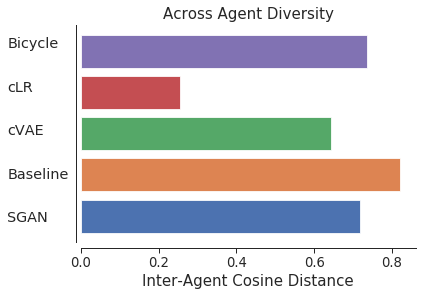

In [84]:
viz = Visualization()
ax = viz.plot.init_subplot(title='Across Agent Diversity')
order = ['Bicycle', 'cLR', 'cVAE', 'Baseline', 'SGAN'][::-1]

for i, model in enumerate(order):
    ax.barh([i], cosine_scores[model], height=0.8, alpha=1)
    ax.text(-0.22, 0.08+i*1/len(cosine_scores), model, transform=ax.transAxes,
           va='bottom', ha='left')

#ax.legend()
ax.set_xlabel('Inter-Agent Cosine Distance')
ax.set_yticks([])
#ax.set_xlabel('Accuracy (L1 Distance)')
#ax.grid(True)

plt.show()

In [ ]:
.bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)[source]

### Distance matrix

In [44]:
model='BicycleBaseline'
dataset, trainloader = data_loader(in_len=8,
                                   out_len=12,
                                   batch_size=64,
                                   num_workers=1,
                                   path=experiment.test_dir,
                                   shuffle=True)
generator = models[model]['generator']
solver.generator = generator
ckpt = models[model]['ckpt']
solver.load_generator(model_path + ckpt)
out = solver.test(trainloader)
xy_pred = norm_scene(out['xy_pred'])
xy_out = norm_scene(out['xy_out'])

In [45]:
def dissimilarity_matrix(xy_pred, xy_out):
    max_size = np.max([x.size for x in xy_out]) # number of features (flattend seq dimensions)
    # zero pad and flatten, to put into (obs, feature) matrix
    scenes = np.zeros([len(xy_out), max_size])
    for i, scene in enumerate(xy_out):
        scenes[i, :scene.size] = scene.flatten()
    scenes_pred = np.zeros([len(xy_pred), max_size])
    for i, scene in enumerate(xy_pred):
        scenes_pred[i, :scene.size] = scene.flatten()
    M = np.vstack((scenes, scenes_pred))
    dissimilarity = squareform(pdist(M, metric='cosine'))
    return dissimilarity, pdist(scenes, metric='cosine').sum(), pdist(scenes_pred, metric='cosine').sum()

In [46]:
dm = dissimilarity_matrix(xy_pred, xy_out)

In [48]:
dm[1:]

(875.4802928263807, 807.8928958832445)

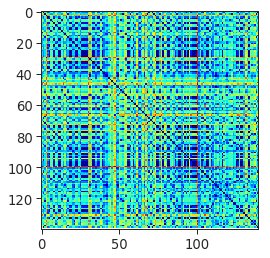

In [47]:
plt.imshow(dm[0], cmap='jet')

### Look into normalization

In [13]:
viz = Visualization()

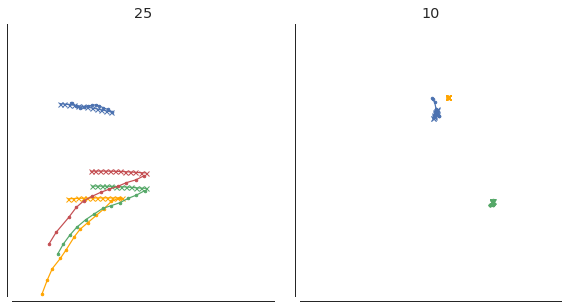

In [25]:
solver.generator = models['Bicycle']['generator']
solver.load_generator(model_path + models['Bicycle']['ckpt'])
out = solver.test(trainloader)

viz.trajectories(out, scenes=[25, 10], input_truth=False, ground_truth=True)

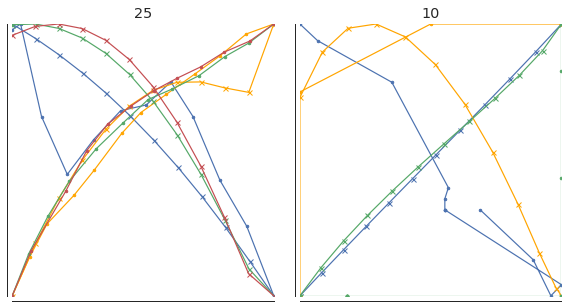

In [23]:
out2 = out
out2['xy_pred'] = norm_scene(out['xy_pred'])
out2['xy_out'] = norm_scene(out['xy_out'])
viz.trajectories(out2, scenes=[25, 10], input_truth=False, ground_truth=True,xlim=(0, 1), ylim=(0, 1))

In [24]:
out['xy_out']

[array([[[1.        , 0.5692307 ],
         [1.        , 0.6938775 ]],
 
        [[0.94366205, 0.78461534],
         [0.9044222 , 0.8979589 ]],
 
        [[0.89514863, 0.6410257 ],
         [0.8245363 , 0.7755101 ]],
 
        [[0.8560251 , 0.85128206],
         [0.77175456, 0.6938775 ]],
 
        [[0.78090763, 0.9282052 ],
         [0.7232524 , 0.71428615]],
 
        [[0.6791863 , 1.        ],
         [0.639087  , 0.6734689 ]],
 
        [[0.5524257 , 1.        ],
         [0.5577746 , 0.46938756]],
 
        [[0.43818468, 0.9076924 ],
         [0.47646216, 0.95918375]],
 
        [[0.32237872, 0.6923077 ],
         [0.35663337, 1.        ]],
 
        [[0.20970266, 0.5179486 ],
         [0.24679029, 0.61224496]],
 
        [[0.10798122, 0.19487163],
         [0.11269615, 0.51020384]],
 
        [[0.        , 0.        ],
         [0.        , 0.        ]]], dtype=float32),
 array([[[1.        , 1.        ],
         [1.        , 1.        ]],
 
        [[0.9051282 , 0.9071731 ],
 

In [26]:
out['xy_out']

[array([[[ 4.87,  7.16],
         [ 6.29,  7.  ]],
 
        [[ 4.51,  7.58],
         [ 5.62,  7.1 ]],
 
        [[ 4.2 ,  7.3 ],
         [ 5.06,  7.04]],
 
        [[ 3.95,  7.71],
         [ 4.69,  7.  ]],
 
        [[ 3.47,  7.86],
         [ 4.35,  7.01]],
 
        [[ 2.82,  8.  ],
         [ 3.76,  6.99]],
 
        [[ 2.01,  8.  ],
         [ 3.19,  6.89]],
 
        [[ 1.28,  7.82],
         [ 2.62,  7.13]],
 
        [[ 0.54,  7.4 ],
         [ 1.78,  7.15]],
 
        [[-0.18,  7.06],
         [ 1.01,  6.96]],
 
        [[-0.83,  6.43],
         [ 0.07,  6.91]],
 
        [[-1.52,  6.05],
         [-0.72,  6.66]]], dtype=float32), array([[[ 7.17,  5.45],
         [ 6.73,  5.97]],
 
        [[ 6.43,  5.23],
         [ 5.98,  5.8 ]],
 
        [[ 5.67,  5.16],
         [ 5.21,  5.74]],
 
        [[ 4.94,  4.95],
         [ 4.45,  5.61]],
 
        [[ 4.26,  4.71],
         [ 3.76,  5.6 ]],
 
        [[ 3.54,  4.54],
         [ 3.03,  5.39]],
 
        [[ 2.82,  4.35],
       

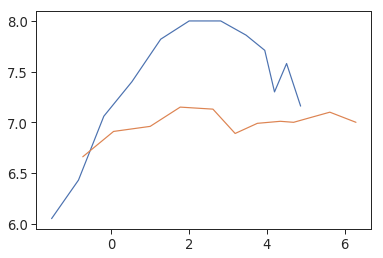

In [34]:
def plot_single(x):
    x = x.transpose((1, 0, 2))
    for agent in x:
        plt.plot(agent[:, 0], agent[:, 1])

x = out['xy_out'][0]
plot_single(x)

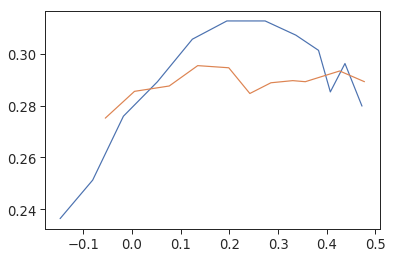

In [44]:
y = torch.Tensor(x)
y = (x/x.norm(dim=0, keepdim=True)).numpy()
plot_single(y)

In [43]:
x.shape

torch.Size([12, 2, 2])